# Anuj Rajan Lalla
# B22AI061
# Speech PA2 - Q1

## Parts I and II are implemented, the dataset was downloaded from the link and stored locally, the trial pairs were also extracted and stored locally in a .txt file

In [ ]:
import os
import torch
import soundfile as sf
import numpy as np
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar


/home/rishabh/miniconda3/envs/octcpll/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Performing speaker verification of pretrained model of WaveLM Base plus on the vox celeb dataset and computing required metrics

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# Loading pre-trained feature extractor and model from Hugging Face
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-base-plus-sv')
model = WavLMForXVector.from_pretrained('microsoft/wavlm-base-plus-sv')
model.to(device)
model.eval()      # set model to evaluation mode

# Helper function to load and resample audio to 16kHz
def load_audio(file_path, target_sr=16000):
    audio, sr = sf.read(file_path)
    if sr != target_sr:
        import librosa
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    return audio

trial_file = "trial_pairs.txt"
base_audio_dir = "vox1/wav"           # Audio files are in the "wav/" directory

# Initialize lists to store similarity scores and corresponding ground-truth labels
similarity_scores = []
ground_truth_labels = []

# Read the trial pairs file
with open(trial_file, "r") as f:
    lines = f.readlines()

for line in tqdm(lines, desc="Processing trial pairs"):
    parts = line.strip().split()
    if len(parts) < 3:
        continue  # Skip malformed lines
    label = int(parts[0])  # 1 if same speaker, 0 if different

    file1 = os.path.join(base_audio_dir, parts[1])
    file2 = os.path.join(base_audio_dir, parts[2])

    # Loading both audio files, ensuring they are 16kHz
    audio1 = load_audio(file1, target_sr=16000)
    audio2 = load_audio(file2, target_sr=16000)

    # Preparing inputs for the model using the feature extractor
    inputs = feature_extractor([audio1, audio2], sampling_rate=16000, return_tensors="pt", padding=True)
    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Extracting speaker embeddings
    with torch.no_grad():
        embeddings = model(**inputs).embeddings
    # Normalizing embeddings along the last dimension
    embeddings = torch.nn.functional.normalize(embeddings, dim=-1)

    # Computing cosine similarity between the two embeddings
    cosine_sim = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=-1).item()

    similarity_scores.append(cosine_sim)
    ground_truth_labels.append(label)

    # This is done as the GPU was going out of memory
    del inputs, embeddings
    torch.cuda.empty_cache()

# Convert lists to NumPy arrays for metric computation
similarity_scores = np.array(similarity_scores)
ground_truth_labels = np.array(ground_truth_labels)

# Compute the ROC curve to derive operating characteristics
fpr, tpr, thresholds = roc_curve(ground_truth_labels, similarity_scores, pos_label=1)

# 1. Calculate EER: find the threshold where false acceptance rate (FPR) equals false rejection rate (1 - TPR)
diff = np.abs((1 - tpr) - fpr)
eer_index = np.nanargmin(diff)
eer_threshold = thresholds[eer_index]
eer = fpr[eer_index]
print("EER: {:.2%}".format(eer))

# 2. Compute TAR@1%FAR: find TPR at the point where FPR is as close as possible to 1%
idx_far = np.argmin(np.abs(fpr - 0.01))
tar_at_1_far = tpr[idx_far]
print("TAR@1%FAR: {:.2%}".format(tar_at_1_far))


# 3. Compute Speaker Identification Accuracy:
predictions = np.array([1 if score >= eer_threshold else 0 for score in similarity_scores])
identification_accuracy = np.mean(predictions == ground_truth_labels)
print("Speaker Identification Accuracy: {:.2%}".format(identification_accuracy))

Running on device: cuda


Some weights of the model checkpoint at microsoft/wavlm-base-plus-sv were not used when initializing WavLMForXVector: ['wavlm.encoder.pos_conv_embed.conv.weight_g', 'wavlm.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMForXVector were not initialized from the model checkpoint at microsoft/wavlm-base-plus-sv and are newly initialized: ['wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a d

EER: 4.94%
TAR@1%FAR: 78.28%
Speaker Identification Accuracy: 95.05%


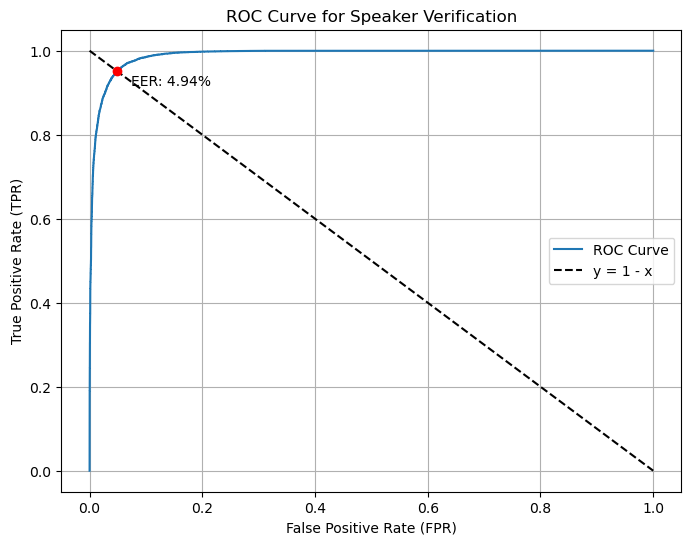

In [ ]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [1, 0], 'k--', label="y = 1 - x")  # Diagonal line where FAR = FRR
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for Speaker Verification")
plt.legend()

# Mark the EER point on the ROC curve
eer_tpr = tpr[eer_index]
plt.plot(fpr[eer_index], eer_tpr, "ro", label="EER Point")
plt.annotate(f"EER: {eer:.2%}", (fpr[eer_index], eer_tpr), textcoords="offset points", xytext=(10,-10))
plt.grid(True)
plt.show()

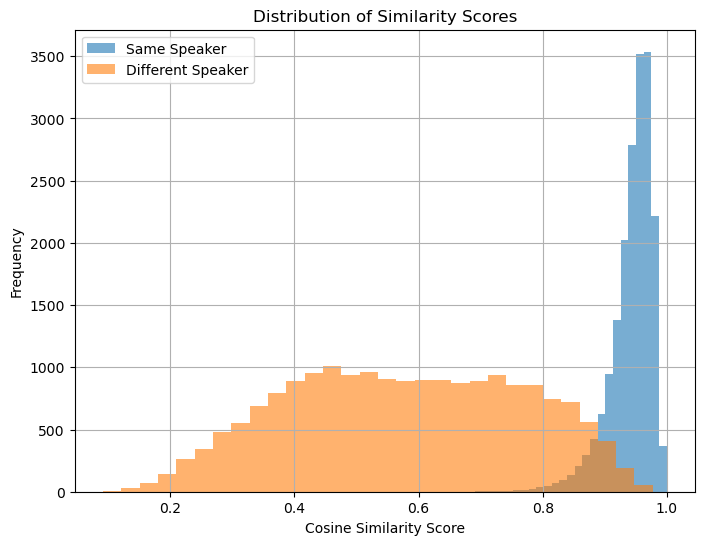

In [ ]:
plt.figure(figsize=(8, 6))
same_scores = similarity_scores[ground_truth_labels == 1]
diff_scores = similarity_scores[ground_truth_labels == 0]
plt.hist(same_scores, bins=30, alpha=0.6, label="Same Speaker")
plt.hist(diff_scores, bins=30, alpha=0.6, label="Different Speaker")
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.legend()
plt.grid(True)
plt.show()

# Preparing and using VoxCeleb 2 dataset to finetune the model using LoRA and ArcFace loss

In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset
import soundfile as sf
from pydub import AudioSegment
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

def load_audio(file_path, target_sr=16000):
    # For M4A files using pydub
    if file_path.lower().endswith('.m4a'):
        # Load using pydub
        audio_seg = AudioSegment.from_file(file_path, format="m4a")
        # Set channels to mono and change frame rate
        audio_seg = audio_seg.set_channels(1)
        audio_seg = audio_seg.set_frame_rate(target_sr)
        # Get raw audio data as a numpy array (pydub returns 16-bit PCM)
        samples = np.array(audio_seg.get_array_of_samples()).astype(np.float32)
        # Normalize samples to [-1, 1]
        samples /= (2**15)
        return samples
    else:
        # For wav files, using soundfile
        audio, sr = sf.read(file_path)
        if sr != target_sr:
            import librosa
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        return audio

class VoxCeleb2DirDataset(Dataset):
    def __init__(self, base_dir, speaker_dirs, target_sr=16000):
        """
        base_dir: base directory for the audio files, e.g., "vox2/aac"
        speaker_dirs: list of speaker folder names (e.g., "id00001", "id00002", ...)
        """
        self.samples = []  # list of (file_path, speaker_label)
        self.target_sr = target_sr

        for label_idx, speaker in enumerate(speaker_dirs):
            speaker_path = os.path.join(base_dir, speaker)
            # In each speaker folder, assume there's one or more subdirectories
            for subfolder in os.listdir(speaker_path):
                subfolder_path = os.path.join(speaker_path, subfolder)
                if os.path.isdir(subfolder_path):

                    for fname in os.listdir(subfolder_path):
                        if fname.lower().endswith(('.m4a', '.wav')):
                            file_path = os.path.join(subfolder_path, fname)
                            self.samples.append((file_path, label_idx))
                            break

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        audio = load_audio(file_path, self.target_sr)
        return audio, label

# Base directory for VoxCeleb2 audio files
vox2_base_dir = "vox2/aac"

# List all speaker directories and sort them in ascending order
all_speaker_dirs = [d for d in os.listdir(vox2_base_dir) if os.path.isdir(os.path.join(vox2_base_dir, d))]
all_speaker_dirs = sorted(all_speaker_dirs)

# Use first 100 speaker IDs for training and next 18 for testing
train_speaker_dirs = all_speaker_dirs[:100]
test_speaker_dirs = all_speaker_dirs[100:118]

print("Number of training speakers:", len(train_speaker_dirs))
print("Number of testing speakers:", len(test_speaker_dirs))


from torch.utils.data import DataLoader
from transformers import Wav2Vec2FeatureExtractor

# Use the same feature extractor as before
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-base-plus-sv')

def collate_fn(batch, max_length=16000*10):
    # Batch is a list of tuples: (audio, label)
    audios, labels = zip(*batch)

    audios = [audio[:max_length] for audio in audios]
    inputs = feature_extractor(audios, sampling_rate=16000, return_tensors="pt", padding=True)

    inputs.pop("input_ids", None)
    return inputs, torch.tensor(labels)

train_dataset = VoxCeleb2DirDataset(vox2_base_dir, train_speaker_dirs, target_sr=16000)
test_dataset = VoxCeleb2DirDataset(vox2_base_dir, test_speaker_dirs, target_sr=16000)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

from transformers import WavLMForXVector
from peft import LoraConfig, get_peft_model

# Load the pre-trained model
model = WavLMForXVector.from_pretrained('microsoft/wavlm-base-plus-sv')
model.to(device)
model.eval()  # We'll set it to train mode later for fine-tuning

# Configure LoRA parameters
lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj"]
)

# Wrap model with LoRA
model = get_peft_model(model, lora_config)
# Freeze base model parameters (only LoRA parameters will be updated)
for name, param in model.named_parameters():
    if "lora" not in name:
        param.requires_grad = False

model.train()  # Set model to training mode for fine-tuning

import torch.nn as nn
import torch.nn.functional as F

class ArcFaceClassifier(nn.Module):
    def __init__(self, embedding_size, num_classes):
        super(ArcFaceClassifier, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings):
        normalized_embeddings = F.normalize(embeddings, dim=1)
        normalized_weight = F.normalize(self.weight, dim=1)
        logits = F.linear(normalized_embeddings, normalized_weight)
        return logits

class ArcFaceLoss(nn.Module):
    def __init__(self, s=32.0, m=0.2):
        super(ArcFaceLoss, self).__init__()
        self.s = s
        self.m = m
        # Register constants as buffers to ensure they move with the module's device
        self.register_buffer("cos_m", torch.cos(torch.tensor(m)))
        self.register_buffer("sin_m", torch.sin(torch.tensor(m)))
        self.register_buffer("th", torch.cos(torch.tensor(torch.pi - m)))
        self.register_buffer("mm", self.sin_m * m)

    def forward(self, logits, labels):
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = F.one_hot(labels, num_classes=logits.size(1)).float()
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        loss = F.cross_entropy(output, labels)
        return loss

num_classes = 100  # Since we use first 100 identities for training
embedding_size = 512  # Ensure this matches the model's output dimension

classifier = ArcFaceClassifier(embedding_size, num_classes)
classifier.to(device)

arcface_loss_fn = ArcFaceLoss(s=32.0, m=0.2)
arcface_loss_fn.to(device)


Number of training speakers: 100
Number of testing speakers: 18


ArcFaceLoss()

In [ ]:
import torch.cuda.amp as amp
from tqdm import tqdm
import gc


optimizer = torch.optim.Adam(
    list(filter(lambda p: p.requires_grad, model.parameters())) + list(classifier.parameters()),
    lr=1e-4
)

num_epochs = 3
model.train()
classifier.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        with amp.autocast():
            embeddings = model(**inputs).embeddings  # (batch, embedding_size)
            embeddings = torch.nn.functional.normalize(embeddings, dim=-1)
            logits = classifier(embeddings)
            loss = arcface_loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        del inputs, labels, embeddings, logits, loss
        torch.cuda.empty_cache()
        gc.collect()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/3: 100%|██████████| 65/65 [14:14<00:00, 13.15s/it]


Epoch 1/3, Loss: 11.2873


Epoch 2/3: 100%|██████████| 65/65 [13:24<00:00, 12.38s/it]


Epoch 2/3, Loss: 10.5755


Epoch 3/3: 100%|██████████| 65/65 [13:18<00:00, 12.28s/it]

Epoch 3/3, Loss: 10.1388


In [ ]:
# Save the fine-tuned LoRA model and ArcFace classifier
save_dir = "fine_tuned_model"
os.makedirs(save_dir, exist_ok=True)
model.save_pretrained(os.path.join(save_dir, "wavlm_lora"))
classifier_path = os.path.join(save_dir, "arcface_classifier.pt")
torch.save(classifier.state_dict(), classifier_path)
print("Fine-tuned model and classifier saved.")



Fine-tuned model and classifier saved.


In [ ]:
trial_file = 'trial_pairs.txt'
base_audio_dir = 'vox1/wav'

Evaluating pre-trained model:


Evaluating: 100%|██████████| 37611/37611 [28:08<00:00, 22.27it/s]  


EER: 5.23%
TAR@1%FAR: 74.45%
Speaker Identification Accuracy: 94.77%


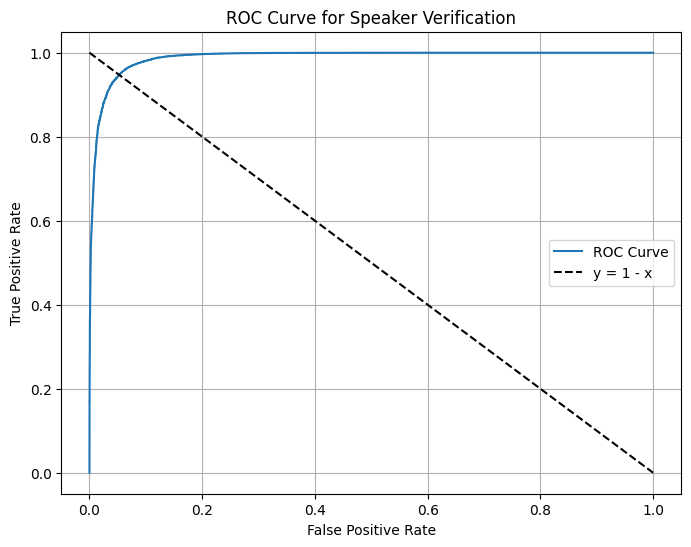

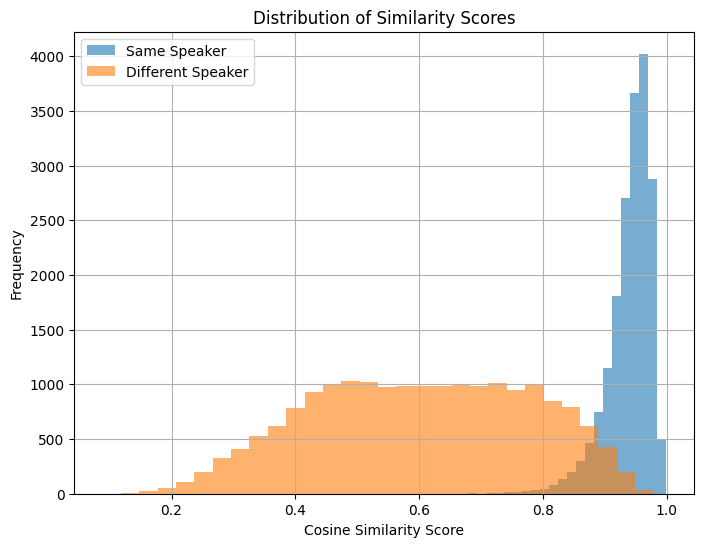

Evaluating fine-tuned model:


Evaluating: 100%|██████████| 37611/37611 [24:02<00:00, 26.08it/s]  


EER: 4.94%
TAR@1%FAR: 78.29%
Speaker Identification Accuracy: 95.06%


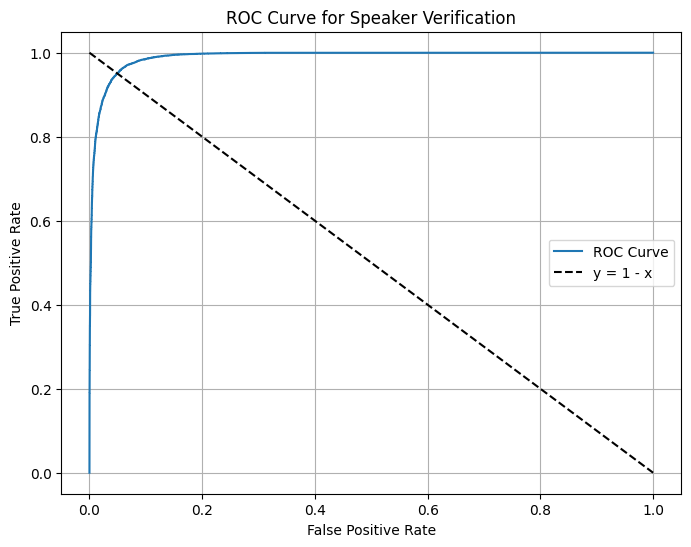

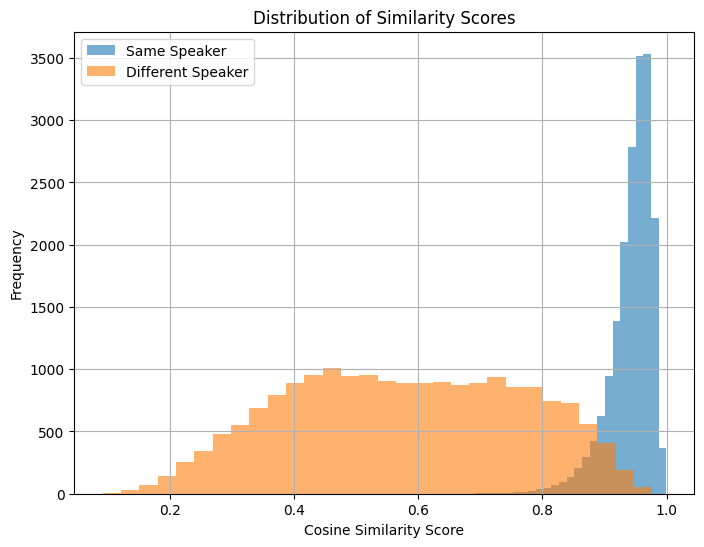

In [ ]:
from transformers import Wav2Vec2FeatureExtractor
import matplotlib.pyplot as plt

# Re-use the same feature extractor as before
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-base-plus-sv')

# Load fine-tuned model and classifier
fine_tuned_model = WavLMForXVector.from_pretrained(os.path.join(save_dir, "wavlm_lora"))
fine_tuned_model.to(device)
fine_tuned_model.eval()

fine_tuned_classifier = ArcFaceClassifier(embedding_size, num_classes)
fine_tuned_classifier.load_state_dict(torch.load(classifier_path))
fine_tuned_classifier.to(device)
fine_tuned_classifier.eval()

# Define a function to evaluate a speaker verification model on the VoxCeleb1 trial pairs
def evaluate_speaker_verification(model, classifier, trial_file, base_audio_dir):
    similarity_scores = []
    ground_truth_labels = []

    with open(trial_file, "r") as f:
        lines = f.readlines()

    for line in tqdm(lines, desc="Evaluating"):
        parts = line.strip().split()
        if len(parts) < 3:
            continue
        label = int(parts[0])
        file1 = os.path.join(base_audio_dir, parts[1])
        file2 = os.path.join(base_audio_dir, parts[2])
        audio1 = load_audio(file1, target_sr=16000)
        audio2 = load_audio(file2, target_sr=16000)

        inputs = feature_extractor([audio1, audio2], sampling_rate=16000, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            embeddings = model(**inputs).embeddings
        embeddings = torch.nn.functional.normalize(embeddings, dim=-1)

        cosine_sim = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=-1).item()
        similarity_scores.append(cosine_sim)
        ground_truth_labels.append(label)
        del inputs, embeddings
        torch.cuda.empty_cache()

    similarity_scores = np.array(similarity_scores)
    ground_truth_labels = np.array(ground_truth_labels)

    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(ground_truth_labels, similarity_scores, pos_label=1)
    diff = np.abs((1 - tpr) - fpr)
    eer_index = np.nanargmin(diff)
    eer_threshold = thresholds[eer_index]
    eer = fpr[eer_index]

    idx_far = np.argmin(np.abs(fpr - 0.01))
    tar_at_1_far = tpr[idx_far]

    predictions = np.array([1 if score >= eer_threshold else 0 for score in similarity_scores])
    identification_accuracy = np.mean(predictions == ground_truth_labels)

    print("EER: {:.2%}".format(eer))
    print("TAR@1%FAR: {:.2%}".format(tar_at_1_far))
    print("Speaker Identification Accuracy: {:.2%}".format(identification_accuracy))

    # Plot ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0,1], [1,0], 'k--', label="y = 1 - x")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Speaker Verification")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot histograms for same vs. different speaker similarity scores
    plt.figure(figsize=(8,6))
    same_scores = similarity_scores[ground_truth_labels==1]
    diff_scores = similarity_scores[ground_truth_labels==0]
    plt.hist(same_scores, bins=30, alpha=0.6, label="Same Speaker")
    plt.hist(diff_scores, bins=30, alpha=0.6, label="Different Speaker")
    plt.xlabel("Cosine Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Similarity Scores")
    plt.legend()
    plt.grid(True)
    plt.show()

print("Evaluating pre-trained model:")
evaluate_speaker_verification(model, classifier, trial_file, base_audio_dir)

print("Evaluating fine-tuned model:")
evaluate_speaker_verification(fine_tuned_model, fine_tuned_classifier, trial_file, base_audio_dir)